# Test Notebook to learn how to read in various tide gauge records

### Some sources of tide gauge data

https://www.psmsl.org/

http://www.ioc-sealevelmonitoring.org/

http://uhslc.soest.hawaii.edu/data/

### Load in some modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

from tidegauge_functions import read_tidegauge_psmsl

# %matplotlib notebook
%matplotlib inline
# %matplotlib widget

### A place for function development
NOTE that the function below is the "test" function (notice different function name) used for development in this notebook.  Production function is loaded from  `tidegauge_functions.py`

In [2]:
def test_read_tidegauge_psmsl(path, columns=None):
    """
    Read and parse PSMSL tide gauge data

    CSV Columns:
        'YEAR', 'MONTH', 'DAY', 'SSH', possibly 'HOUR'

    Parameters
    ----------
    path : str
        Filesystem path to data file
    columns: List

    Returns
    -------
    pandas.DataFrame
        Gravity data indexed by datetime.
    """
    columns = ['YEAR', 'MONTH', 'DAY', 'SSH']

    df = pd.read_csv(path, header=None, engine='c')

#     print(f'len(df.columns): {len(df.columns)}')
#     print(f'len(columns): {len(columns)}')
    
    if len(df.columns) == len(columns):
#         columns += ['unknown']
        df.columns = ['YEAR', 'MONTH', 'DAY', 'SSH']
        dt = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
    else:
        df.columns = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'SSH']
        dt = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR']])
        
    # missing data to NaNs
    df['SSH'] = df['SSH'].replace(-32767, np.nan)
    
    # create datetime index
    df.index = pd.DatetimeIndex(dt)
    
    
    return df

In [3]:
dir_in = 'data/tidegauge'
# file_in = 'h820'
file_in = 'd820'
ext = '.csv'

filepath = os.path.join(dir_in, file_in + ext)

df = read_tidegauge_psmsl(filepath)

In [4]:
df.describe()

,YEAR,MONTH,DAY,SSH
count,2158.000000,2158.000000,2158.000000,2005.000000
mean,2016.960612,6.528267,15.760426,4514.105237
std,1.753948,3.476244,8.794916,113.750938
min,2014.000000,1.000000,1.000000,4038.000000
25%,2015.000000,3.000000,8.000000,4444.000000
50%,2017.000000,7.000000,16.000000,4510.000000
75%,2018.000000,10.000000,23.000000,4576.000000
max,2020.000000,12.000000,31.000000,4982.000000


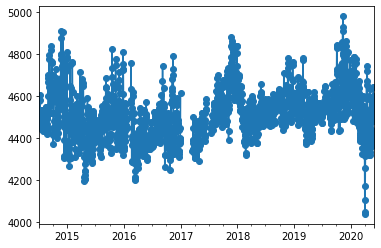

In [5]:
ax = df['SSH'].plot(marker='o')
# ax.set_xlim(pd.Timestamp('2015-08-01'), pd.Timestamp('2015-09-01'))
# ax.set_ylim(4300, 4600)

### Histogram

- What is the mean?
- Is distribution symmetric?

/Users/dporter/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dporter/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


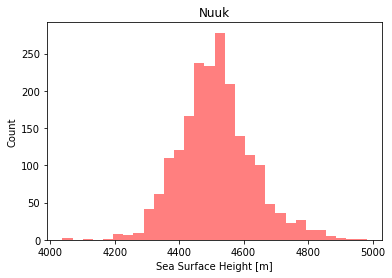

In [6]:
plt.figure(facecolor='white')
plt.hist(df['SSH'], bins=30, alpha=0.5,color='red')
plt.title('Nuuk');
plt.xlabel("Sea Surface Height [m]")
plt.ylabel("Count")
plt.show()

### Plotting using **matplotlib.pyplot** method instead of built-in Pandas
use `plt.plot()`

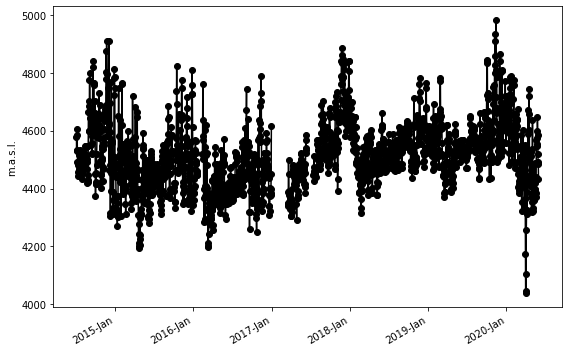

In [7]:
    # Set up
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# Plot
ln1 = ax.plot(df['SSH'], '-ok')

# Customize
ax.set_title('')
# ax.set_xlim([my_levels[0], my_levels[-1]])
# ax.set_ylim(my_plotmin, 0)
plt.ylabel('m.a.s.l.')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(f'figs/test_tsplot_SSH_{file_in}.png')

### Plot each year on top of eachother
Do this by masking by `df.index.year`

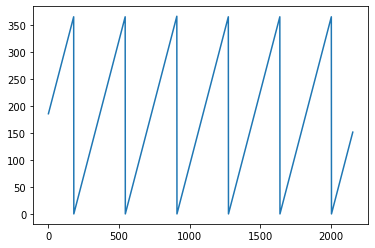

In [8]:
plt.plot(df.index.dayofyear)

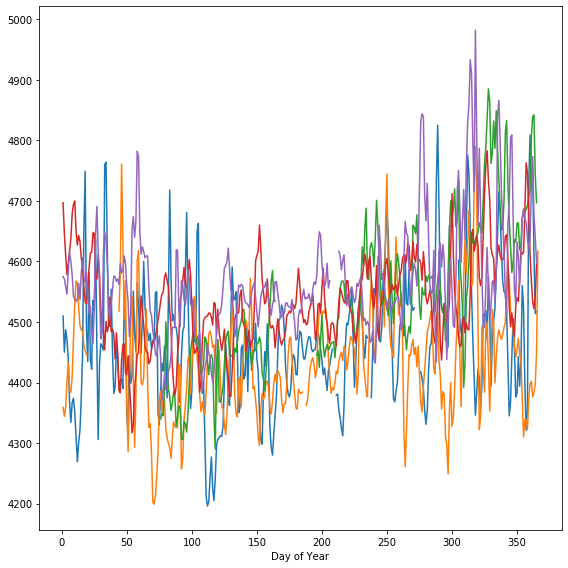

In [9]:
# Set up
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Plot
ax.plot(df[df.index.year==2015].index.dayofyear, df[df.index.year==2015]['SSH'])
ax.plot(df[df.index.year==2016].index.dayofyear, df[df.index.year==2016]['SSH'])
ax.plot(df[df.index.year==2017].index.dayofyear, df[df.index.year==2017]['SSH'])
ax.plot(df[df.index.year==2018].index.dayofyear, df[df.index.year==2018]['SSH'])
ax.plot(df[df.index.year==2019].index.dayofyear, df[df.index.year==2019]['SSH'])
# ax.plot(df[df.index.year==2016]['SSH'])
plt.xlabel('Day of Year')
plt.tight_layout()

## Create some climatologies using `groupby` method
Monthly and Daily

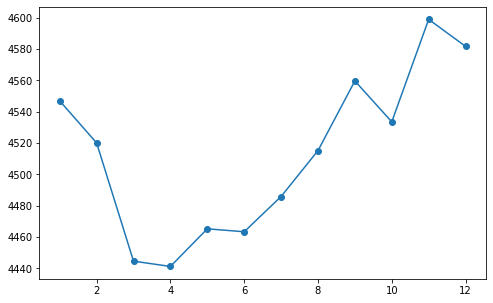

In [10]:
fig = plt.figure(figsize=(8,5))
monthly_climatology = df.groupby(df.index.month).mean()
monthly_climatology.SSH.plot(marker='o')


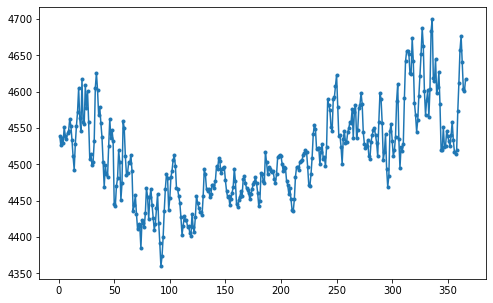

In [11]:
daily_climatology = df.groupby(df.index.dayofyear).mean() #aggregate({'SSH_DAILY_MEAN': 'mean',
#                                                             'SSH_DAILY_MAX': 'max',
#                                                             'SSH_DAILY_MIN': 'min'})
fig = plt.figure(figsize=(8,5))
daily_climatology.SSH.plot(marker='.')

### Standardize
Subtract the mean and divide by standard deviation

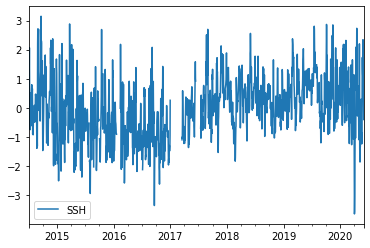

In [12]:
def standardize(x):
    return (x - x.mean())/x.std()

anomaly = df.groupby(df.index.month).transform(standardize)
anomaly.plot(y='SSH')

## Hourly data

In [13]:
file_in = 'h820'
ext = '.csv'

filepath = os.path.join(dir_in, file_in + ext)

hourly = test_read_tidegauge_psmsl(filepath)
hourly

,YEAR,MONTH,DAY,HOUR,SSH
2014-07-04 12:00:00,2014,7,4,12,4647.0
2014-07-04 13:00:00,2014,7,4,13,5141.0
2014-07-04 14:00:00,2014,7,4,14,5426.0
2014-07-04 15:00:00,2014,7,4,15,5444.0
2014-07-04 16:00:00,2014,7,4,16,5229.0
...,...,...,...,...,...
2020-05-31 19:00:00,2020,5,31,19,5214.0
2020-05-31 20:00:00,2020,5,31,20,4781.0
2020-05-31 21:00:00,2020,5,31,21,4229.0
2020-05-31 22:00:00,2020,5,31,22,3722.0


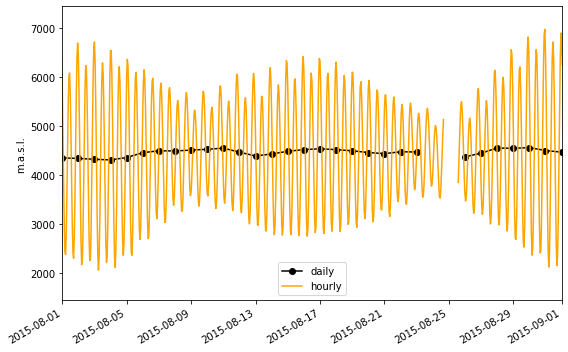

In [14]:
# Set up
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# Plot
ln1 = plt.plot(df['SSH'], '-ok', label='daily')
ln2 = plt.plot(hourly['SSH'], color='orange', label='hourly')

# Customize
ax.set_title('')
ax.set_xlim(pd.Timestamp('2015-08-01'), pd.Timestamp('2015-09-01'))
# ax.set_ylim(my_plotmin, 0)
plt.ylabel('m.a.s.l.')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.savefig(f'figs/test_tsplot_SSH_{file_in}+d.png')



## Function for reading in MONTHLY historical (Spada) Nuuk data

Links:
- http://www.ioc-sealevelmonitoring.org/ssc/stationdetails.php?id=SSC-godt
- https://ccar.colorado.edu/altimetry/


In [15]:
def test_read_tidegauge_monthly(monthly_file):
    column_names=['Year', 'SSH', 'unknown1', 'unknown2']
    df = pd.read_csv(monthly_file, header=None, delimiter=';', names=column_names)
    
    # NaNs
    df['SSH'] = df['SSH'].replace(-99999, np.nan) 
    
    # Datetime operations
    year = df['Year'].astype(int)
    month = ((df['Year'] - year) * 12).astype(int) + 1
    dt = pd.to_datetime(year.astype(str) + month.astype(str), format='%Y%m')
    df = df.rename(columns={'Year': 'YearDec'})
    df.index = pd.DatetimeIndex(dt)

    return df


df_monthly = test_read_tidegauge_monthly('data/tidegauge/915.csv')

# convert cm to mm
# df_monthly['SSH'] = df_monthly['SSH'] * 10

df_monthly.head()

,YearDec,SSH,unknown1,unknown2
Year,,,,
1958-05-01,1958.3750,-108.0,0,0
1958-06-01,1958.4583,18.0,0,0
1958-07-01,1958.5417,55.0,0,0
1958-08-01,1958.6250,21.0,0,0
1958-09-01,1958.7083,182.0,0,0


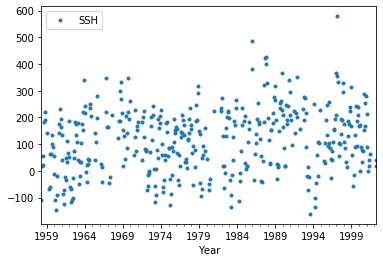

In [16]:
df_monthly.plot.line(y='SSH', linestyle='',marker='.')

### now calculate trend and compare to Spada

Trend = 0.21 mm/yr
                            OLS Regression Results                            
Dep. Variable:                    SSH   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     18.48
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           2.15e-05
Time:                        12:16:01   Log-Likelihood:                -2546.6
No. Observations:                 412   AIC:                             5097.
Df Residuals:                     410   BIC:                             5105.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.9691     11.535 

Text(0.5, 0.98, 'ta')

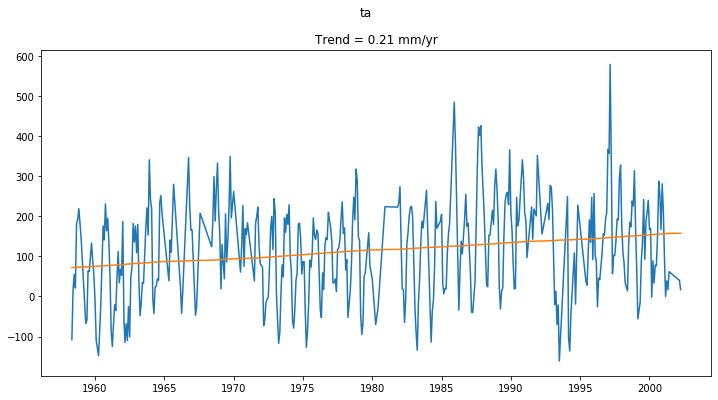

In [17]:
from tidegauge_functions import calc_OLS_tides

res = calc_OLS_tides(df_monthly, 'SSH')
trend = res.params.x1

print(f"Trend = {trend * 1:.2f} mm/yr")

print(res.summary())

fig, ax = plt.subplots(1, 1, figsize=(12,6));
ax.plot(df_monthly['SSH'].dropna().index, df_monthly['SSH'].dropna().values, label='trend')
ax.plot(df_monthly['SSH'].dropna().index, [res.params.x1*i + res.params.const for i in np.arange(len(df_monthly['SSH'].dropna()))])
# ax[1].plot(df['Vertical'].dropna().index, res.resid.values);
# ax[1].plot(df['Vertical'].dropna().index, np.abs(res.resid.values));
# ax[1].hlines(0, 0, len(res.resid), color='k');
ax.set_title(f"Trend = {res.params.x1 * 1:.2f} mm/yr");
# ax[1].set_title("Residuals");
plt.suptitle(f"{filepath[-21:4]}")
# plt.savefig(f'figs/test_GPS_OLS_{file_in[:4]}.png')

# Example reading in CCAR data

In [18]:
from tidegauge_functions import find_skiprows_startofline

infile = 'data/CCAR/CCAR_altimetry_642500N_517500W_tidegauge_820.csv'

i_skip = find_skiprows_startofline(infile, 'time')
print(i_skip)

df_CCAR = pd.read_csv(infile, header=None, skiprows=i_skip)

df_CCAR

17


,0,1,2,3,4
0,1992.752225,-3.797284,NaN,2014.518138,2.629235
1,1992.765914,-2.456437,NaN,2014.531828,-3.870765
2,1992.779603,-1.942245,NaN,2014.545517,-5.170765
3,1992.793292,-4.629961,NaN,2014.559206,0.329235
4,1992.806982,-8.471432,NaN,2014.572895,-4.970765
...,...,...,...,...,...
1916,2019.008214,7.011869,NaN,NaN,NaN
1917,2019.021903,4.850990,NaN,NaN,NaN
1918,2019.035592,2.914328,NaN,NaN,NaN
1919,2019.049281,1.872063,NaN,NaN,NaN


In [19]:
def test_read_CCAR_altimetry(ccar_file):
    i_skip = find_skiprows_startofline(ccar_file, 'time')
    column_names=['Year', 'SSH', '', 'Year2', 'SSH_tides']
    df = pd.read_csv(ccar_file, 
                     skiprows=i_skip,
                     header=None, 
                     delimiter=',', 
                     names=column_names)
    
    # NaNs
#     df['SSH'] = df['SSH'].replace(-99999, np.nan) 
    
    ## Datetime operations
    year = df['Year'].astype(int)
    doy = ((df['Year'] - year) * 365).astype(int) + 1  # TODO: This might be off by one day...
    dt = pd.to_datetime(year.astype(str) + doy.astype(str), format='%Y%j')
    df = df.rename(columns={'Year': 'YearDec'})
    df.index = pd.DatetimeIndex(dt)
    
    # delete unused columns
    df = df.drop([df.columns[2], 'Year2', 'SSH_tides'], axis=1)

    return df

infile = 'data/CCAR/CCAR_altimetry_642500N_517500W_tidegauge_820.csv'
df_CCAR = test_read_CCAR_altimetry(infile)
df_CCAR

,YearDec,SSH
Year,,
1992-10-01,1992.752225,-3.797284
1992-10-06,1992.765914,-2.456437
1992-10-11,1992.779603,-1.942245
1992-10-16,1992.793292,-4.629961
1992-10-21,1992.806982,-8.471432
...,...,...
2019-01-03,2019.008214,7.011869
2019-01-08,2019.021903,4.850990
2019-01-13,2019.035592,2.914328


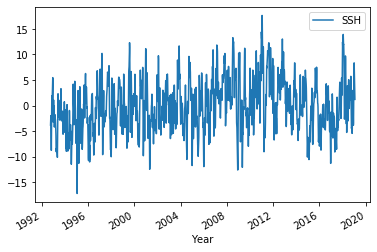

In [20]:
df_CCAR.plot.line(y='SSH')

## plotting examples

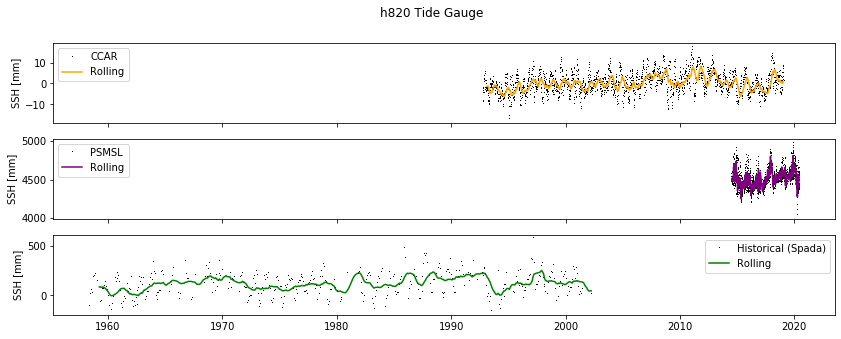

In [21]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(14,5))
fig.suptitle('Sharing both axes')

axes[0].plot(df_CCAR.SSH, 
            color='black', marker=',', linestyle='', label='CCAR')
axes[0].plot(df_CCAR.SSH.rolling(30).mean(), 
            color='orange', linestyle='-', label='Rolling')
axes[1].plot(df.SSH, 
            color='black', marker=',', linestyle='', label='PSMSL')
axes[1].plot(df.SSH.interpolate().rolling(12).mean(), 
            color='purple', linestyle='-', label='Rolling')
axes[2].plot(df_monthly.SSH, 
            color='black', marker=',', linestyle='', label='Historical (Spada)')
axes[2].plot(df_monthly.SSH.interpolate().rolling(12).mean(), 
            color='green', linestyle='-', label='Rolling')

plt.suptitle(f'{file_in} Tide Gauge')
axes[0].set_ylabel('SSH [mm]')
axes[0].legend()
axes[1].set_ylabel('SSH [mm]')
axes[1].legend()
axes[2].set_ylabel('SSH [mm]')
axes[2].legend()
plt.savefig('figs/test_lineplot_stacked_tidegauge_SARIMAX_forecast_KULU.png')

## Use CCAR satellite atlimetetry to extend historical Nuuk gauge

In [65]:
# df_monthly.SSH.loc[df_CCAR.index[0]:df_monthly.index[-1]]
# df_CCAR.SSH.loc[df_CCAR.index[0]:df_monthly.index[-1]]
# df.SSH.loc[df.index[0]:df_CCAR.index[-1]]

df_CCAR['SSH_mm'] = df_CCAR.SSH * 10

mean_hist = df_monthly.SSH.loc[df_CCAR.index[0]:df_monthly.index[-1]].mean()
mean_ccar = df_CCAR.SSH_mm.loc[df_CCAR.index[0]:df_monthly.index[-1]].mean()
mean_cont = df.SSH.loc[df.index[0]:df_CCAR.index[-1]].mean()

print(f'Mean Historical: {mean_hist}')
print(f'Mean CCAR: {mean_ccar}')
print(f'Mean PSMSL: {mean_cont}')

df_CCAR['SSH_adj'] = (df_CCAR['SSH_mm'] + (mean_hist - mean_ccar))
df['SSH_adj'] = (df['SSH'] + ((mean_hist - mean_ccar) - mean_cont))



Mean Historical: 128.25
Mean CCAR: -14.758600593937764
Mean PSMSL: 4502.002636783124


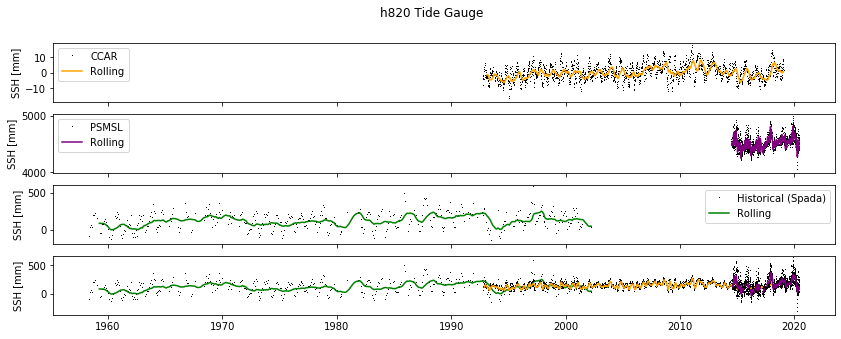

In [69]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(14,5))
fig.suptitle('Sharing both axes')

axes[0].plot(df_CCAR.SSH, 
            color='black', marker=',', linestyle='', label='CCAR')
axes[0].plot(df_CCAR.SSH.rolling(30).mean(), 
            color='orange', linestyle='-', label='Rolling')
axes[1].plot(df.SSH, 
            color='black', marker=',', linestyle='', label='PSMSL')
axes[1].plot(df.SSH.interpolate().rolling(12).mean(), 
            color='purple', linestyle='-', label='Rolling')
axes[2].plot(df_monthly.SSH, 
            color='black', marker=',', linestyle='', label='Historical (Spada)')
axes[2].plot(df_monthly.SSH.interpolate().rolling(12).mean(), 
            color='green', linestyle='-', label='Rolling')

axes[3].plot(df_monthly.SSH, 
            color='black', marker=',', linestyle='', label='Historical (Spada)')
axes[3].plot(df_monthly.SSH.interpolate().rolling(12).mean(), 
            color='green', linestyle='-', label='Rolling')
axes[3].plot(df_CCAR.SSH_adj, 
            color='black', marker=',', linestyle='', label='Adjusted')
axes[3].plot(df_CCAR.SSH_adj.interpolate().rolling(12).mean(), 
            color='orange', linestyle='-', label='Rolling')
axes[3].plot(df.SSH_adj, 
            color='black', marker=',', linestyle='', label='PSMSL')
axes[3].plot(df.SSH_adj.rolling(30).mean(), 
            color='purple', linestyle='-', label='Rolling')

plt.suptitle(f'{file_in} Tide Gauge')
axes[0].set_ylabel('SSH [mm]')
axes[0].legend()
axes[1].set_ylabel('SSH [mm]')
axes[1].legend()
axes[2].set_ylabel('SSH [mm]')
axes[2].legend()
axes[3].set_ylabel('SSH [mm]')
# axes[3].legend()

plt.savefig('figs/lineplot_stacked_TG_Nuuk_CCARPSMSLSPADA+combined.png')

              YearDec     SSH  unknown1  unknown2     SSH_adj  SSH_mm    YEAR  \
1958-05-01  1958.3750  -108.0       0.0       0.0 -108.000000     NaN     NaN   
1958-06-01  1958.4583    18.0       0.0       0.0   18.000000     NaN     NaN   
1958-07-01  1958.5417    55.0       0.0       0.0   55.000000     NaN     NaN   
1958-08-01  1958.6250    21.0       0.0       0.0   21.000000     NaN     NaN   
1958-09-01  1958.7083   182.0       0.0       0.0  182.000000     NaN     NaN   
...               ...     ...       ...       ...         ...     ...     ...   
2020-05-27        NaN  4585.0       NaN       NaN  226.005964     NaN  2020.0   
2020-05-28        NaN  4518.0       NaN       NaN  159.005964     NaN  2020.0   
2020-05-29        NaN  4492.0       NaN       NaN  133.005964     NaN  2020.0   
2020-05-30        NaN  4483.0       NaN       NaN  124.005964     NaN  2020.0   
2020-05-31        NaN  4434.0       NaN       NaN   75.005964     NaN  2020.0   

            MONTH   DAY  
1

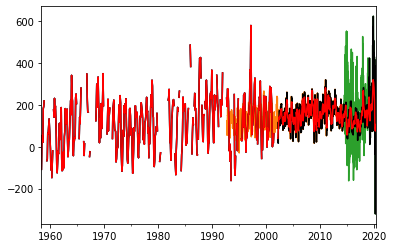

In [145]:
df_monthly['SSH_adj'] = df_monthly['SSH']
df_combined = []
# df_combined = pd.concat([df_monthly['SSH_adj'],
#                          df_CCAR['SSH_adj'].loc[df_monthly.index[-1]:df_CCAR.index[-1]],
#                          df['SSH_adj'].loc[df_CCAR.index[-1]:df.index[-1]]],
#                          keys=['monthly', 'ccar', 'psmsl'])
df_combined = pd.concat([df_monthly,
                         df_CCAR.loc[df_monthly.index[-1]:df_CCAR.index[-1]],
                         df.loc[df_CCAR.index[-1]:df.index[-1]]])

# dt = pd.to_datetime(df_combined['Year'])
# df_combined.index = pd.DatetimeIndex(dt)
# df = df.drop('Date', axis=1)

print(df_combined)

df_monthly['SSH_adj'].plot()
df_CCAR['SSH_adj'].plot()
df['SSH_adj'].plot()
df_combined['SSH_adj'].plot(color='black')
df_combined['SSH_adj'].resample('M').mean().plot(color='red')



In [162]:
def plot_OLS_overlay_smoothing(df, res, site, var, data_units, simpletrend=True):
    import matplotlib.pyplot as plt
    from tidegauge_functions import convert_trend_toyearly
    
    fig, ax = plt.subplots(1, 1, figsize=(12,6));
    ax.plot(df[var].dropna().index, df[var].dropna().values, 
            label='Data', marker=',', linestyle='', color='black')
    
    ## Plot linea model
    if simpletrend:
        ax.plot((df[var].index[0], df[var].index[-1]), 
            (res.params.x1*1 + res.params.const, res.params.x1*df.shape[0] + res.params.const),
               label='Trend', linestyle='--', color='purple')
    else:
            ax.plot(df[var].index, [res.params.x1*i + res.params.const for i in np.arange(len(df[var]))])

    ##
    df[var].interpolate().rolling(window = 12).mean().plot(label='Rolling', color='black')
    
    ## zero line
#     ax.plot((df[var].index[0], df[var].index[-1]), (0, 0), 'k')
    
    ## customize
    trend = convert_trend_toyearly(df_combined_MM, res)
    ax.set_title(f"Trend = {trend:.2f} mm/yr");
    
    ##
    ax.set_ylabel(data_units)
    plt.suptitle(f"{site}")
    plt.legend()
    plt.savefig(f'figs/test_GPS_OLS_{site}.png')

                            OLS Regression Results                            
Dep. Variable:                SSH_adj   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     45.64
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           3.25e-11
Time:                        14:14:27   Log-Likelihood:                -3782.7
No. Observations:                 629   AIC:                             7569.
Df Residuals:                     627   BIC:                             7578.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.5974      7.896     10.461      0.0

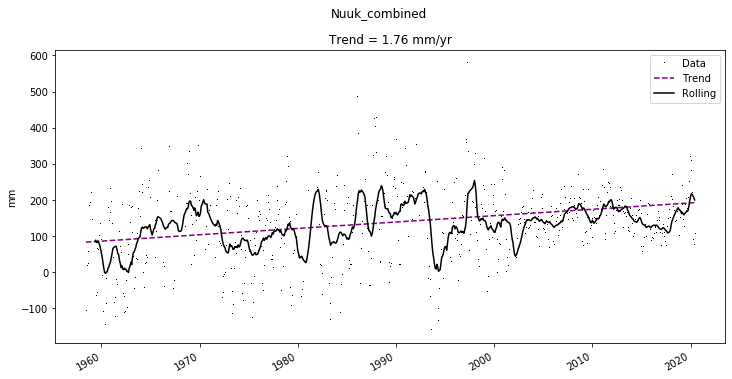

In [164]:
from tidegauge_functions import calc_OLS_tides, convert_trend_toyearly, plot_OLS_overlay

df_combined_MM = df_combined.resample('M').mean()

res = calc_OLS_tides(df_combined_MM, 'SSH_adj')
print(res.summary())

trend = convert_trend_toyearly(df_combined_MM, res)
print(trend)

plot_OLS_overlay_smoothing(df_combined_MM, res, 'Nuuk_combined', 'SSH_adj', 'mm', simpletrend=True)